In [9]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import umap
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# load cleaned data
df = pd.read_csv("../data_processed/cleaned_customers.csv")


In [10]:
base_features = [
    "TotalTransactionAmount",
    "TotalTransactionCount",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "AvgUtilization",
    "InactiveMonths",
    "ContactsLast12M",
    "RelationshipCount"
]

X = df[base_features].copy()


In [11]:
X["avg_tx_amount"] = X["TotalTransactionAmount"] / (X["TotalTransactionCount"].replace(0, 1))
X["debt_to_limit"] = X["Total_Revolving_Bal"] / (X["Credit_Limit"].replace(0, np.nan))
X["spend_per_product"] = X["TotalTransactionAmount"] / (X["RelationshipCount"].replace(0, 1))

# Fill missing or extreme values
X["debt_to_limit"] = X["debt_to_limit"].fillna(0).clip(0, 10)
X["avg_tx_amount"] = X["avg_tx_amount"].clip(lower=0)
X.head()


,TotalTransactionAmount,TotalTransactionCount,Credit_Limit,Total_Revolving_Bal,AvgUtilization,InactiveMonths,ContactsLast12M,RelationshipCount,avg_tx_amount,debt_to_limit,spend_per_product
0,1144,42,12691.0,777,0.061,1,3,5,27.238095,0.061224,228.800000
1,1291,33,8256.0,864,0.105,1,2,6,39.121212,0.104651,215.166667
2,1887,20,3418.0,0,0.000,1,0,4,94.350000,0.000000,471.750000
3,1171,20,3313.0,2517,0.760,4,1,3,58.550000,0.759734,390.333333
4,816,28,4716.0,0,0.000,1,0,5,29.142857,0.000000,163.200000


In [12]:
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print("✅ Data scaled. Shape:", X_scaled.shape)


✅ Data scaled. Shape: (10127, 11)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


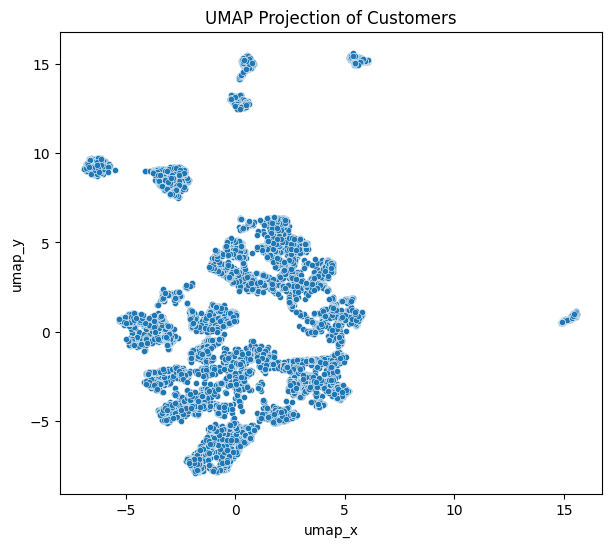

In [13]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
umap_coords = reducer.fit_transform(X_scaled)
umap_df = pd.DataFrame(umap_coords, columns=["umap_x","umap_y"])

plt.figure(figsize=(7,6))
sns.scatterplot(x="umap_x", y="umap_y", data=umap_df, s=20)
plt.title("UMAP Projection of Customers")
plt.show()


In [14]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10)
cluster_labels = clusterer.fit_predict(X_scaled)
df["cluster_hdbscan"] = cluster_labels

print("Cluster counts:\n", pd.Series(cluster_labels).value_counts())


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster counts:
  6    7770
-1    1175
 1     249
 4     238
 0     206
 5     175
 2     160
 3     154
Name: count, dtype: int64


Silhouette Score: 0.3681077996512562


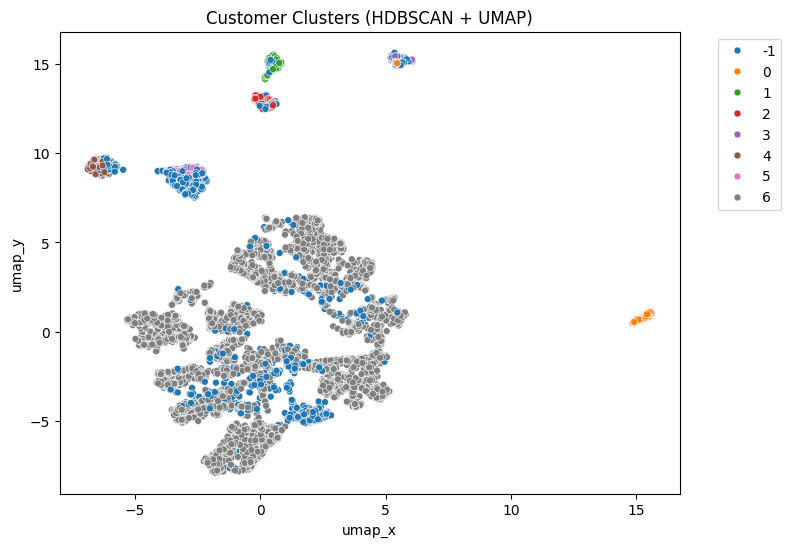

In [15]:
mask = df["cluster_hdbscan"] != -1
if mask.sum() > 5:
    score = silhouette_score(X_scaled.loc[mask], df.loc[mask, "cluster_hdbscan"])
    print("Silhouette Score:", score)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=umap_df["umap_x"],
    y=umap_df["umap_y"],
    hue=df["cluster_hdbscan"],
    palette="tab10",
    s=25
)
plt.title("Customer Clusters (HDBSCAN + UMAP)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


In [16]:
import os
import pandas as pd

# ✅ Combine dataframe and UMAP coordinates
cluster_data = pd.concat([df, umap_df], axis=1)

# ✅ Build a robust save path (works anywhere)
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
output_path = os.path.join(project_root, "data_processed", "umap_clusters.csv")

# ✅ Create folder if missing
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# ✅ Save
cluster_data.to_csv(output_path, index=False)
print("✅ Clustering complete! File saved at:", output_path)

# ✅ Quick verification
check = pd.read_csv(output_path)
print("Preview of saved data:")
display(check.head())


✅ Clustering complete! File saved at: c:\Users\ADMIN\Desktop\Financial_Behavior_Segmentation_Projet\data_processed\umap_clusters.csv
Preview of saved data:


,Customer_ID,Age,Gender,Dependents,Education,MaritalStatus,Income,CardType,Tenure,RelationshipCount,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,TotalTransactionAmount,TotalTransactionCount,TransactionChangeRatio,AvgUtilization,cluster_hdbscan,umap_x,umap_y
0,768805383,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,777,11914.0,1.335,1144,42,1.625,0.061,6,-1.534661,0.327230
1,818770008,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,864,7392.0,1.541,1291,33,3.714,0.105,6,0.944396,2.643753
2,713982108,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,0,3418.0,2.594,1887,20,2.333,0.000,-1,1.958342,2.869484
3,769911858,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,2517,796.0,1.405,1171,20,2.333,0.760,-1,4.688304,-1.064017
4,709106358,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,0,4716.0,2.175,816,28,2.500,0.000,6,2.267537,2.431210


In [17]:
os.makedirs("../data_processed", exist_ok=True)
cluster_data = pd.concat([df, umap_df], axis=1)
cluster_data.to_csv("../data_processed/umap_clusters.csv", index=False)
print("✅ Clustering complete! Saved to data_processed/umap_clusters.csv")


✅ Clustering complete! Saved to data_processed/umap_clusters.csv
